In [205]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
import mpl_recipes
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [207]:
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import scipy as sp
import seaborn as sns
from collections import namedtuple, defaultdict
from itertools import izip, izip_longest, chain, tee
from pprint import pprint
from copy import copy
import os
import json
import itertools
import re
import random
import math
import cPickle as pickle
from matplotlib_venn import venn2, venn3

In [208]:
from scipy.stats import lognorm, spearmanr, norm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib as mpl
from matplotlib.mlab import PCA
from matplotlib.pylab import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from IPython.display import HTML, Image

In [209]:
from hindsight.pathways import get_designs, add_all_heterologous_pathways
from hindsight import (
    normalize_by_carbons, download_or_load_model_me_placeholder,
    find_summary_lethal_reactions, find_lethal_reactions,
)
from hindsight.bibtex import split_on_comma_or_space
from hindsight.variables import min_biomass, growth_coupled_cutoff
from hindsight.plots import (
    calculate_model_growth_coupled, plot_model_growth_coupled,
    calculate_model_growth_coupled_gradient, plot_model_growth_coupled_gradient,
    plot_model_growth_coupled_gradient_colorbar,
    calculate_model_growth_coupled_categories, plot_model_growth_coupled_categories,
    rename_models
)
from mpl_recipes.utils import add_to_brewer_cmap

In [210]:
# load models
model = download_or_load_model_me_placeholder('iJO1366')
model_heterologous = add_all_heterologous_pathways(model, copy=True)

In [211]:
# load model and make c_sim_order
all_sims = pd.read_pickle('../data/sims_table.pickle')
# TODO move normalize_by_carbons to hindsight sims notebook
all_sims['c_sim_order'] = all_sims.max_secretion.apply(normalize_by_carbons, model=model_heterologous)

In [212]:
all_sims_no_wildtype = all_sims.loc[all_sims.index.map(lambda x: 'wildtype' not in x[0])]

# Common functions

In [213]:
def find_papers_with_gene(sims, gene, drop_duplicates=True):
    if drop_duplicates:
        return (all_sims[all_sims.deletions.str.contains(r'(^|[, ])%s($|,)' % gene)]
                .reset_index()
                .loc[:, ['paper', 'deletions']]
                .drop_duplicates())
    else:
        return (all_sims[all_sims.deletions.str.contains(r'(^|[, ])%s($|,)' % gene)]
                .reset_index()
                .loc[:, ['paper', 'deletions', 'reaction_knockouts']])

In [214]:
def filter_by_gene_deletions(sims):
    """Filter and sort
    
    Filter:
    - sims with no deletions
    - repeat sims for the same paper and target (take just the one with the most deletions)
    
    """
    genes = (sims
             .xs('iJO1366', level=1)
             .dropna(how='any', subset=['deletions', 'reaction_knockouts', 'native', 'target']))

    # take out none's
    genes.deletions = genes.deletions.apply(lambda x: '' if x=='none' else x)
    
    # for all designs in the same paper with the same target, take only the one with the highest gene count
    genes_filtered = genes.reset_index()
    genes_filtered.paper = genes_filtered.paper.apply(lambda x: re.sub(r'_[0-9]', '', x))
    genes_filtered.deletions = (genes_filtered
                                .deletions
                                .apply(split_on_comma_or_space))
    genes_filtered['gene_count'] = genes_filtered.deletions.apply(len)
    genes_filtered = (genes_filtered
                      .groupby(['paper', 'target'])
                      .apply(lambda x: x.sort_values(by='gene_count', ascending=False).iloc[0, :]))
    genes_filtered = (genes_filtered
                      .reset_index(drop=True)
                      .set_index('paper'))
    
    return genes_filtered

# parent strains

In [215]:
all_sims.xs('iJO1366', level='model').loc[:, 'parent'].value_counts()

BW25113                  22
MG1655                   18
W3110                     8
B (ATCC 11303)            7
ATCC 8739                 5
XL1-Blue                  4
W1485                     4
E. coli B                 2
RR1                       2
B (CGSC 2507)             2
ATCC11303 (B)             2
CICIM B0013               2
DSM 14335                 2
BL21                      1
W (ATCC 9637)             1
NZN111/AFP111             1
B                         1
TC4 (K12)                 1
GJT001                    1
K12 (CGSC 4401)           1
YYC202                    1
GJT001; Tolentino1992     1
Name: parent, dtype: int64

# Targets by year

In [216]:
TargetByYear = namedtuple('TargetByYear', ['years',
                                           'targets',
                                           'color_indices',
                                           'sizes',
                                           'legend_sizes',
                                           'year_labels',
                                           'target_labels'])

In [217]:
def range_min_max(l, step=1):
   return range(*[(min(x), max(x)+1, step) for x in [l]][0])

In [218]:
def target_by_year_size_scale(x): return x * 180 - 40

In [219]:
def calculate_target_by_year(all_sims):
    # get target and year
    by_year = all_sims.xs('iJO1366', level='model').reset_index()[['target', 'year', 'citation_key']]
    # ignore anything without a year (wildtype)
    by_year = by_year[by_year.year > 1950]
    # just grab the citations, not the designs
    by_year['citation_key_p_target'] = by_year.citation_key + by_year.target
    by_year = by_year.drop_duplicates(subset='citation_key_p_target')
    counts = by_year.groupby('year')['target'].value_counts()
    counts_ar = pd.DataFrame(counts).unstack(level=0).fillna(0)
    counts_ar.columns = counts_ar.columns.droplevel(0)
    counts_ar = counts_ar.sort_values(by=list(counts_ar.columns), ascending=False)
                             
    x_range = range_min_max(map(int, counts_ar.columns))
    y_range = list(counts_ar.index)
    x = []; y = []; s = []; c = []; actual_s = []
    
    for (year, target), count in counts.iteritems():
        x.append(x_range.index(int(year)))
        y.append(y_range.index(target))
        s.append(target_by_year_size_scale(count))
        actual_s.append(count)
        c.append(y_range.index(target) % 2)
    return TargetByYear(x, y, c, s, actual_s, x_range, y_range)

In [220]:
def plot_targets_by_year(target_by_year_data, ax):
    colors = sns.color_palette('Blues', 4)[-2:]
    c = [colors[i] for i in target_by_year_data.color_indices]
    
    ax.scatter(target_by_year_data.years, target_by_year_data.targets, 
               s=target_by_year_data.sizes, c=c, linewidth=1)
    
    ax.set_xticks(range(len(target_by_year_data.year_labels)))
    ax.set_xticklabels(target_by_year_data.year_labels, rotation=-60)
    ax.set_xlim(-1, len(target_by_year_data.year_labels))
    ax.set_xlabel('Year', labelpad=10, fontsize=17)
    
    ax.set_yticks(range(len(target_by_year_data.target_labels)))
    ax.set_yticklabels(target_by_year_data.target_labels)
    ax.set_ylim(-1, len(target_by_year_data.target_labels))
    ax.set_ylabel('Target molecule', labelpad=10, fontsize=17)
    
    # color the labels
    for i, t in enumerate(ax.yaxis.get_ticklabels()):
        t.set_color(colors[i % 2])
        
    legend_facecolor = 'w'
    size_range = sorted(set(target_by_year_data.legend_sizes))
    lines = [plt.Line2D(range(1), range(1), markersize=math.sqrt(target_by_year_size_scale(x)) / 2.2, 
                        color=legend_facecolor, marker='o', markeredgecolor='k', 
                        markeredgewidth=1,
                        markerfacecolor=colors[1], alpha=1.0) 
             for x in size_range]
    legend = plt.legend(lines, size_range ,numpoints=1, loc='upper left', 
                        markerscale=2, title='Number of papers', frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor('g')

In [221]:
target_by_year_data = calculate_target_by_year(all_sims_no_wildtype)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590 FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


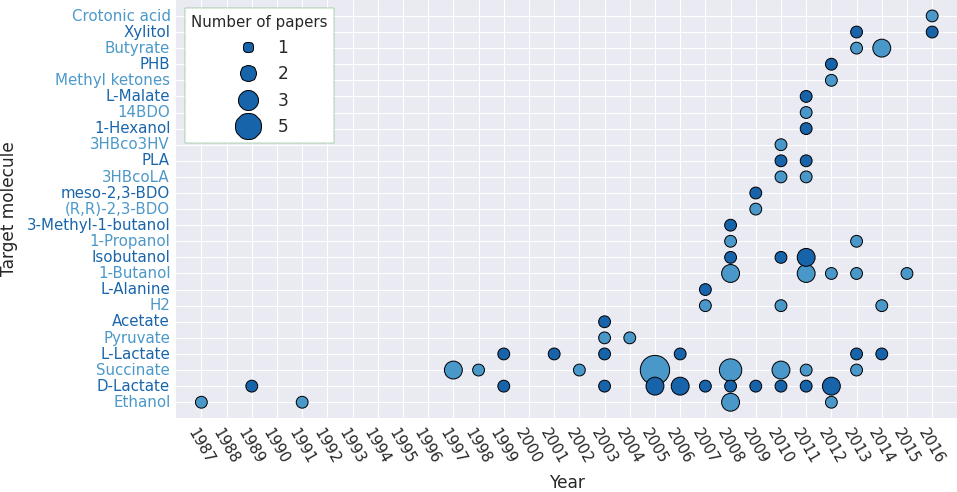

In [222]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(14, 7.5))
    plot_targets_by_year(target_by_year_data, ax)
plt.savefig('/Users/zaking/lab/hindsight/figs/targets-by-year.pdf')

# Number of deletions

In [223]:
DeletionsByType = namedtuple('DeletionsByType', ['categories',
                                                 'hist_dict',
                                                 'bins_dict',
                                                 'means_dict'])

In [224]:
def calculate_deletions(sims, by='gene'):
    if by not in ['gene', 'reaction']:
        raise Exception('by should be "gene" or "reaction"')
        
    genes_filtered = filter_by_gene_deletions(sims)
    
    if by == 'gene':
        genes_filtered['count'] = genes_filtered.deletions.apply(len)
    elif by == 'reaction':
        genes_filtered['count'] = genes_filtered.reaction_knockouts.apply(len)
        
    names = ['native', 'non-native']    

    # get the maximum between all categories
    c_max = 0
    for i, name in enumerate(names):
        count = genes_filtered[genes_filtered['native'] == (name == 'native')]['count']
        c_max = max(c_max, count.max())
        
    hist_dict = {}; bins_dict = {}; mean_dict = {}
    for i, name in enumerate(names):
        count = genes_filtered[genes_filtered['native'] == (name == 'native')]['count']
        
        hist_dict[name], bins_dict[name] = np.histogram(count, bins=range(c_max+2))
        mean_dict[name] = np.mean(count)
        
    return DeletionsByType(names, hist_dict, bins_dict, mean_dict)

In [225]:
def plot_stacked_deletions(deletions_by_type, ax):
    """Make a stacked bar chart for a DeletionsByType object.
    
    """
    colors = sns.color_palette('muted', 2)
    hist_max = max([sum(x) for x in zip(*deletions_by_type.hist_dict.values())])
    
    bars = []; bottom = None
    for i, category in enumerate(deletions_by_type.categories):
        bins = deletions_by_type.bins_dict[category]
        hist = deletions_by_type.hist_dict[category]
        
        width = 0.7 * (bins[1] - bins[0])
        center = [x for x in (bins[:-1] + bins[1:]) / 2]
        
        b = ax.bar(center, 
                   hist, 
                   align='center', 
                   width=width, 
                   color=colors[0] if i==0 else colors[1], 
                   label='%s (mean=%.1f)' % (category.capitalize(), 
                                             deletions_by_type.means_dict[category]),
                   bottom=bottom)
        
        bars.append(b[0])
        bottom = hist
        
    ax.set_xlim(-0.8, bins[-1] + 0.8)
    ax.set_xticks(range(bins[-1]+1))
    
    ax.set_ylabel('Number of designs')
    ax.set_ylim(0, hist_max + 1)
    
    ax.xaxis.set_ticks_position('none')
    l = ax.legend()

In [226]:
gene_deletions_by_type = calculate_deletions(all_sims_no_wildtype)

In [227]:
reaction_deletions_by_type = calculate_deletions(all_sims_no_wildtype, by='reaction')

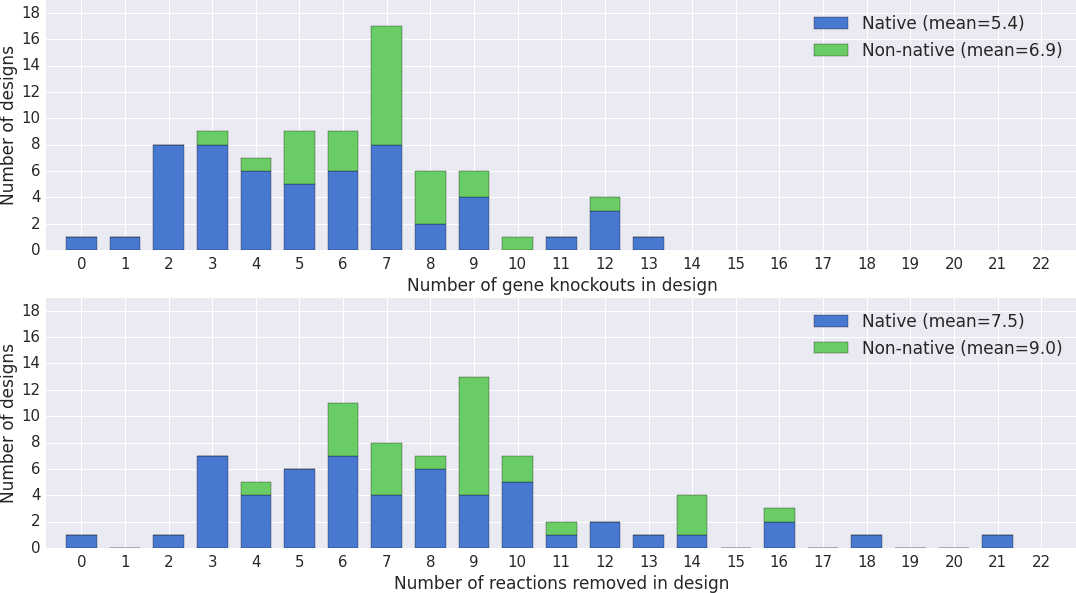

In [228]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15.3, 8.5))
fig.tight_layout()

plot_stacked_deletions(gene_deletions_by_type, ax1)
ax1.set_xlabel('Number of gene knockouts in design')
new_max = 22
ax1.set_xlim(-0.8, new_max + 0.8)
ax1.set_xticks(range(new_max + 1))

plot_stacked_deletions(reaction_deletions_by_type, ax2)
ax2.set_xlabel('Number of reactions removed in design')
new_max = 18
ax1.set_ylim(0, new_max + 1)
ax2.set_ylim(0, new_max + 1)
ax1.set_yticks([x * 2 for x in range((new_max+2)/2)])
ax2.set_yticks([x * 2 for x in range((new_max+2)/2)])

plt.savefig("/Users/zaking/lab/hindsight/figs/gene-knockout-hist-by-type.pdf")

# Genes shared by targets

In [229]:
GenesByTargets = namedtuple('GenesByTargets', ['value_array',
                                               'gene_labels',
                                               'target_labels'])

In [230]:
def calculate_genes_by_targets(sims, order_list=None):
    """
    Arguments
    ---------
    
    sims: The simulation DataFrame.
    
    order_list: A list giving the gene order. If None, they will be sorted by number of hits.
    
    """
    genes_filtered = filter_by_gene_deletions(sims)
    
    # make a 2d array with genes by targets, and counts for values
    
    # count genes
    genes_filtered['gene_count'] = genes_filtered.deletions.apply(len)
    # set the index
    genes_by_targets = genes_filtered.set_index(['target', 'aerobicity'], append=True)
    # convert lists to rows
    genes_by_targets = genes_by_targets.deletions.apply(pd.Series)
    genes_by_targets.columns.name = 'remove'
    # resetting the index seems to be a trick to make nested Series into a DataFrame:
    genes_by_targets = genes_by_targets.stack().reset_index()
    genes_by_targets = genes_by_targets.drop('remove', axis=1).rename(columns={0: 'gene'})
                
    # sort by first year of pub
    first_year = all_sims.reset_index()[['target', 'year']].dropna()
    first_year = (first_year
                  .groupby('target')
                  .apply(lambda x: x.sort_values(by='year', ascending=True).iloc[0, :]))
    first_year.reset_index(drop=True).head()
    genes_by_targets_counts_year = pd.DataFrame.merge(genes_by_targets, first_year, 
                                                      left_on='target', right_on='target', 
                                                      how='left')
    gdf = genes_by_targets_counts_year.sort_values(by='year', ascending=False)
    
    if order_list:
        # sort provided
        genes = order_list
    else:
        # sort by the number of hits a gene has
        count_by_gene = (genes_by_targets
                     .groupby('gene')
                     .paper
                     .count()
                     .reset_index()
                     .rename(columns={'paper': 'gene_count'})
                     .sort_values(by='gene_count', ascending=False))
        genes = count_by_gene.gene.values
    targets = list(gdf.target.unique())
    targets.reverse()
    ar = np.zeros([len(targets), len(genes)])
    summed = np.zeros([1, len(genes)])
    for i, row in gdf.iterrows():
        for i, t in enumerate(targets):
            for j, g in enumerate(genes):
                if g==row.gene and t==row.target:
                    ar[i,j] = ar[i,j] + 1
                    summed[0,j] = summed[0,j] + 1
    return GenesByTargets(ar, genes, targets)

In [231]:
def plot_genes_by_target(genes_by_target, gene_color_indices=None, figsize=[26, 7]):
    color_palette = sns.cubehelix_palette(9, start=1.1, gamma=1.0, rot=0.7, 
                                    hue=1.0, dark=0.2, light=0.9)
    cmap = (mpl.colors.LinearSegmentedColormap.from_list('cubehelix', color_palette))
    
    # get the color bounds
    m = int(genes_by_target.value_array.max())
    bounds = range(0, m + 2)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    # genes by targets plot where an x shows that a gene is used for a target
    fig = plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((16,1), (0, 0), rowspan=14)
    ax2 = plt.subplot2grid((16,1), (15, 0))
    p = ax1.pcolormesh(genes_by_target.value_array, cmap=cmap, norm=norm)
    #fig.colorbar(p)
    xticks = [x + 0.5 for x in range(len(genes_by_target.gene_labels)+1)]
    ax1.xaxis.tick_top()
    ax1.set_xticks(xticks)
    yticks = [x+0.5 for x in range(len(genes_by_target.target_labels)+1)]
    ax1.set_yticks(yticks)
    ax1.set_ylim([0, len(genes_by_target.target_labels)])
    ax1.set_xlim([0, len(genes_by_target.gene_labels)])
    ax1.set_yticklabels([x.strip() for x in genes_by_target.target_labels])
    ax1.set_xticklabels(list(genes_by_target.gene_labels), rotation=-90)
    
    # color gene labels
    label_colors = sns.color_palette('Dark2', max(gene_color_indices.values()) + 1)
    if gene_color_indices is not None:
        for gene, t in zip(genes_by_target.gene_labels, ax1.xaxis.get_ticklabels()):
            if gene in gene_color_indices:
                t.set_color(label_colors[gene_color_indices[gene]])
                
    # add sums
    for i, gene_vals in enumerate(genes_by_target.value_array.T):
        ax1.text(i + 0.5, -0.8, 
                 '%d' % sum(gene_vals), # number of designs
                 ha='center', color=color_palette[-2], fontsize=12)
    for i, target_vals in enumerate(genes_by_target.value_array):
        ax1.text(genes_by_target.value_array.shape[1] + 0.2, i + 0.3, 
                 '%d' % len([x for x in target_vals if x > 0]),  # number of unique genes
                 ha='left', color=color_palette[-2], fontsize=12)

    # If a ListedColormap is used, the length of the bounds array must be
    # one greater than the length of the color list.  The bounds must be
    # monotonically increasing.
    cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap,
                                           norm=norm,
                                           boundaries=bounds,
                                           ticks=[x+0.5 for x in bounds],
                                           spacing='proportional',
                                           orientation='horizontal')
    ax2.set_xticklabels(bounds)
    cb2.set_label('Number of designs')

In [232]:
def get_go_database_cursor():
    import MySQLdb
    connection = MySQLdb.connect(host = 'mysql-amigo.ebi.ac.uk',
                                 user = 'go_select',
                                 passwd = 'amigo',
                                 db = 'go_latest',
                                 port = 4085)
    return connection.cursor()

In [233]:
def get_gene_categories():
    """Get go terms for all E. coli genes, but limit them to a certain 
    set of terms, defined below.
    
    """
    pickle_filename = '../data/saved_gene_categories.pickle'
    try:
        with open(pickle_filename, 'r') as f:
            return pickle.load(f)
    except IOError:
        pass
    out = {}
    
    # database
    cursor = get_go_database_cursor()
    
    group_list = ["regulation of gene expression",
                  "metabolic process"] 
#                  "biological regulation",
#                  "reproduction", "cell killing", "immune system process", 
#                  "cellular process", "biological adhesion", "signaling", "multicellular organismal process", 
#                  "developmental process", "growth", "locomotion", "single-organism process", 
#                  "response to stimulus", "localization", "multi-organism process", 
#                  "cellular component organization or biogenesis"]
    
    query = """
    
select gene_product.symbol, term1.name 

from gene_product 

inner join species on species.id=gene_product.species_id 
inner join association on association.gene_product_id=gene_product.id 
inner join term on term.id=association.term_id 
inner join graph_path on graph_path.term2_id=term.id inner join term as term1 on graph_path.term1_id=term1.id

where gene_product.symbol!='' and term1.name in (%s) and genus='Escherichia' and species='coli'

""" % ', '.join(["'%s'" % g for g in group_list])
       
    cursor.execute(query)
    out = defaultdict(set)
    for g, term in cursor.fetchall():
        out[g].add(term)

    with open(pickle_filename, 'w') as f:
        pickle.dump(out, f)
    return out

In [234]:
def make_indices_for_categories(categories):
    in_legend = ['regulation of gene expression', # order matters
                 'metabolic process'] 
    indices = {}
    for k, v in categories.iteritems():
        try:
            indices[k] = min([in_legend.index(x) for x in v if x in in_legend])
        except ValueError: # empty array
            pass
    return indices

### clustering

In [235]:
genes_by_target = calculate_genes_by_targets(all_sims_no_wildtype)

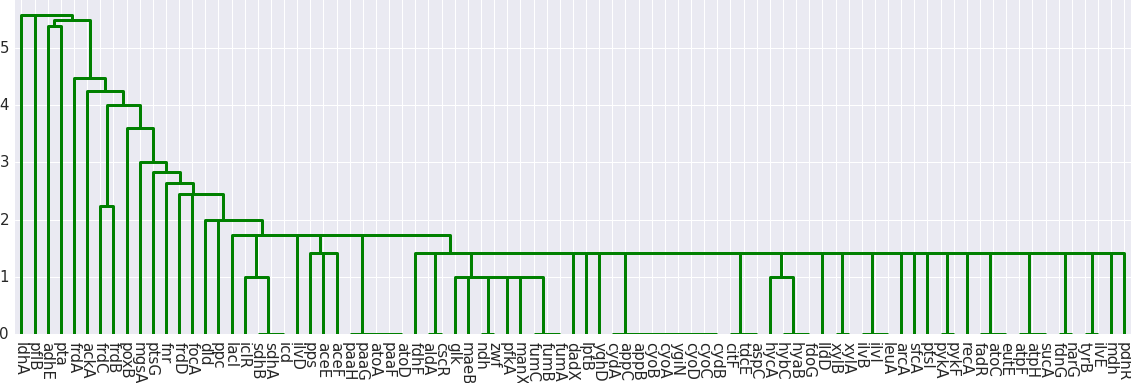

In [236]:
# get the deletions for each design
deletions_df = filter_by_gene_deletions(all_sims_no_wildtype).loc[:,['deletions']]
all_deletions = genes_by_target.gene_labels

for deletion in all_deletions:
    deletions_df.loc[:, deletion] = deletions_df.deletions.apply(lambda x: 1 if deletion in x else 0)
array_df = deletions_df.drop('deletions', axis=1).T

dist = pdist(array_df.values)
# rows = observations (genes), columns = dimensions (designs)
link = linkage(dist)

fig, ax = plt.subplots(figsize=(20, 6))
dend_out = dendrogram(link, labels=all_deletions, ax=ax, count_sort=True, color_threshold=10)
_=ax.set_xticklabels([l.get_text() for l in ax.xaxis.get_ticklabels()], rotation=-90)

dend_gene_label_order = dend_out['ivl']
plt.savefig('/Users/zaking/lab/hindsight/figs/genes-by-targets-dendrogram.pdf')

### heatmap

In [237]:
genes_by_target_sorted = calculate_genes_by_targets(all_sims_no_wildtype, order_list=dend_gene_label_order)

In [238]:
# rm ../data/saved_gene_categories.pickle

In [239]:
gene_categories = get_gene_categories()
# add some that are not in GO
gene_categories['paaF'] = ['metabolic process'] # \cite{Lim2013a}
gene_categories['paaH'] = ['metabolic process']
gene_categories['lptB'] = ['metabolic process'] # ?
gene_categories['pps'] = ['metabolic process']
gene_color_indices = make_indices_for_categories(gene_categories)

In [240]:
def partition(pred, iterable):
    'Use a predicate to partition entries into false entries and true entries. https://docs.python.org/3/library/itertools.html#itertools-recipes'
    # partition(is_odd, range(10)) --> 0 2 4 6 8   and  1 3 5 7 9
    t1, t2 = tee(iterable)
    return filter(lambda x: ~pred(x), t1), filter(pred, t2)
all_cat = {k: gene_categories[k] for k in dend_gene_label_order}
met_cat = len([x for x in all_cat.itervalues() if 'regulation of gene expression' in x])
reg_cat = len([x for x in all_cat.itervalues() if 'regulation of gene expression' not in x])
print 'metabolic %d regulatory %d total %d' % (met_cat, reg_cat, len(all_cat))

metabolic 8 regulatory 77 total 85


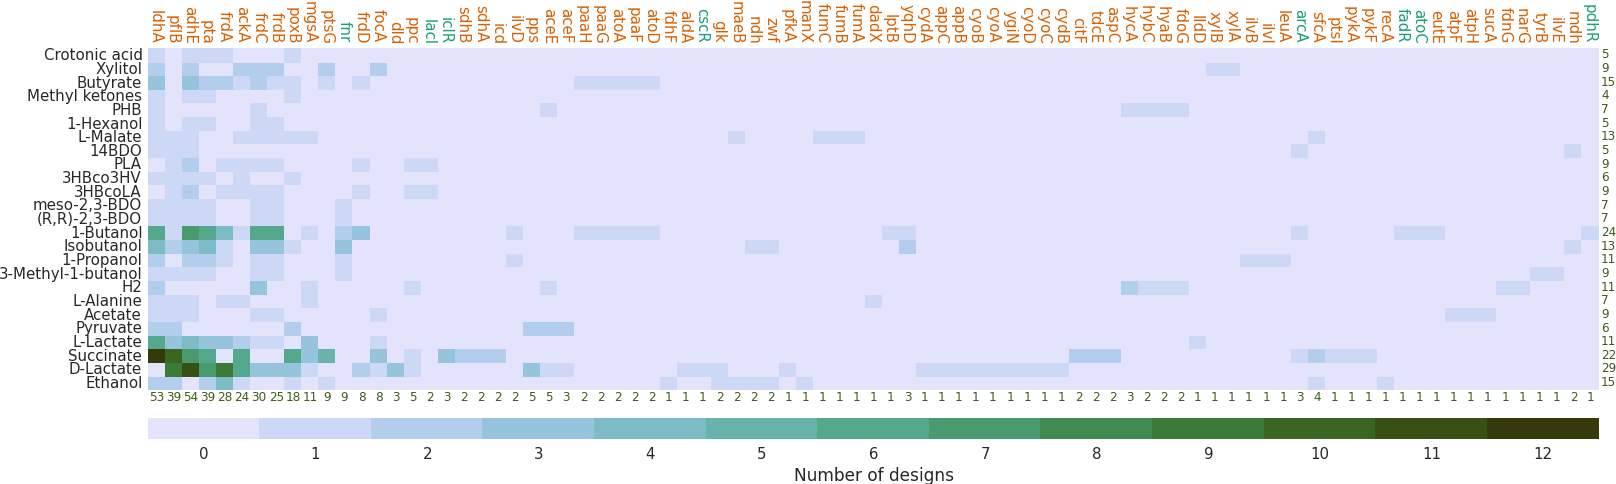

In [241]:
plot_genes_by_target(genes_by_target_sorted, gene_color_indices)
plt.savefig('/Users/zaking/lab/hindsight/figs/genes-by-targets.pdf')

# target Venn diagram

In [242]:
sims_no_wt_ijo = all_sims_no_wildtype.xs('iJO1366', level='model')
n_targets = set(sims_no_wt_ijo[sims_no_wt_ijo.loc[:, 'native']].target.unique())

In [243]:
sims_no_wt_ijo = all_sims_no_wildtype.xs('iJO1366', level='model')
nn_targets = set(sims_no_wt_ijo[sims_no_wt_ijo.loc[:, 'native'] == False].target.unique())
nn_targets.discard('14BDO')
nn_targets.add('1,4-Butanediol')
nn_targets.discard('(R,R)-2,3-BDO')
nn_targets.discard('meso-2,3-BDO')
nn_targets.add('2,3-Butanediol*')
nn_targets.discard('PHB')
nn_targets.add('3-Hydroxybutyrate')

In [244]:
feist_targets = set(['Ethanol', '2-Oxoglutarate', 'D-Lactate', 'Pyruvate', 'Succinate', 'Fumarate', 'Glycerol', 'L-Alanine'])

In [245]:
campodonico_targets = set(['Isobutanol', '1-Butanol', 'Isopropanol', '1-Propanol', '3-Hydroxypropanoate', 'Acrilic acid', 'Acrylamide',
                           '3-Hydroxybutyrate', '2-Keto-butanoic acid', '2-Keto-valeric acid*', '2-Keto-isovaleric acid*', '2,3-Butanediol*',
                           '1,4-Butanediol', '1,3-Propanediol'])
                           # * Number of g-coupled designs was <=2

In [246]:
def make_subsets(set1, set2):
    return [set1.difference(set2), set1.intersection(set2), set2.difference(set1)]
subsets_n = make_subsets(feist_targets, n_targets)
subsets_nn = make_subsets(campodonico_targets, nn_targets)

In [247]:
def draw_labels(v, subsets, alpha=0.8, shift_fn=lambda i: 0.1 * (1 - i)):
    for i, p in enumerate(['10', '11', '01']):
        v.get_patch_by_id(p).set_alpha(0.7)
        label = v.get_label_by_id(p)
        label.set_text('\n'.join(subsets[i]))
        label.set_size(12)
        label.set_linespacing(2)
        label.set_color((0.2, 0.2, 0.2))
        label.set_horizontalalignment(['right', 'center', 'left'][i])
        label.set_position([sum(x) for x in zip(label.get_position(), (shift_fn(i), 0))])
    return v

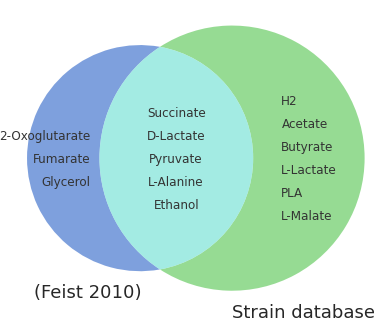

In [248]:
figure, ax = plt.subplots(figsize=(7, 7))
draw_labels(venn2([feist_targets, n_targets], 
                   set_labels=['(Feist 2010)', 'Strain database'],
                   set_colors = sns.color_palette('muted', 2),
                   ax=ax),
            subsets_n)
figure.savefig('/Users/zaking/lab/hindsight/figs/shared-targets-feist-2010.pdf')

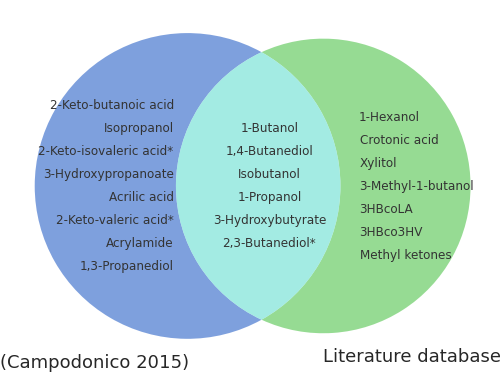

In [249]:
figure, ax = plt.subplots(figsize=(9, 9))
draw_labels(venn2([campodonico_targets, nn_targets], 
                   set_labels=['(Campodonico 2015)', 'Literature database'],
                   set_colors = sns.color_palette('muted', 2),
                   ax=ax),
            subsets_nn,
            shift_fn=lambda i: 0.17 * (1.2 - i))
figure.savefig('/Users/zaking/lab/hindsight/figs/shared-targets-campodonico-2015.pdf')

# Lethal genotypes

In [250]:
models = ['e_coli_core', 'iJR904', 'iAF1260', 'iAF1260b', 'iJO1366', 'ME']
df = all_sims_no_wildtype.growth_rate.unstack('model')[models]
# deal with nan's
df[df.isnull()] = 0
counts = df[df < min_biomass].count()

In [251]:
model_gc = calculate_model_growth_coupled(all_sims_no_wildtype, models=models)
model_not_gc = [model_gc.total - x for x in model_gc.counts]

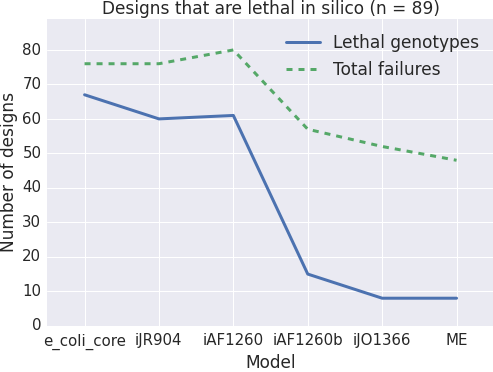

In [252]:
fig, ax = plt.subplots()
#ax.bar([x+0.1 for x in range(len(counts))], counts)
ax.plot([x + 0.5 for x in range(len(counts))], counts, '-', label='Lethal genotypes')
ax.plot([x + 0.5 for x in range(len(counts))], model_not_gc, '--', label='Total failures')
ax.set_xticklabels(models)
ax.set_title('Designs that are lethal in silico (n = %d)' % len(df))
ax.set_xlabel('Model')
ax.set_ylabel('Number of designs')
#ax.set_xlim(-0.5, len(models) - 0.5)
ax.set_xticks([x+0.5 for x in range(len(models))])
ax.set_ylim(top=len(df))
ax.legend(loc='upper right')
fig.savefig('/Users/zaking/lab/hindsight/figs/lethal-designs.pdf')

# frd knockouts

In [253]:
PieData = namedtuple('PieData', ['labels',
                                 'amounts',
                                 'title'])

In [254]:
def calculate_gene_pie(sims, gene_contains):
    filt = filter_by_gene_deletions(sims)
    total = len(filt)
    has = len(filt[filt.deletions.apply(lambda x: any([gene_contains in g for g in x]))])
    percents = [float(x) / total for x in [has, total - has]]
    return PieData(['%d%% of designs have %s knockouts' % (round(percents[0] * 100), gene_contains),
                    '%d%%' % round(percents[1] * 100)],
                   percents,
                   'Fraction of designs')

In [255]:
def plot_pie(pie_data, axis):
    colors = sns.color_palette('muted', len(pie_data.amounts))
    patches, texts = ax.pie(pie_data.amounts, labels=pie_data.labels,
                            startangle=90, colors=colors)
    axis.set_title(pie_data.title)

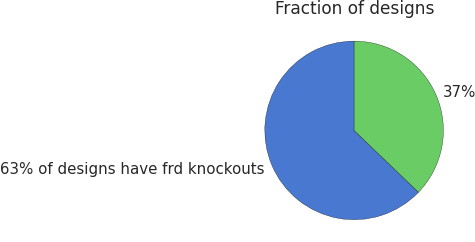

In [256]:
frd_pie = calculate_gene_pie(all_sims_no_wildtype[all_sims_no_wildtype.aerobicity != 'aerobic'], 'frd')
# make a square figure and axes
fix, ax = plt.subplots(figsize=(4,4))
plot_pie(frd_pie, ax)
plt.savefig('/Users/zaking/lab/hindsight/figs/frd-pie.pdf')

# Categorize

In [257]:
growth_coupled_categories = calculate_model_growth_coupled_categories(all_sims_no_wildtype)

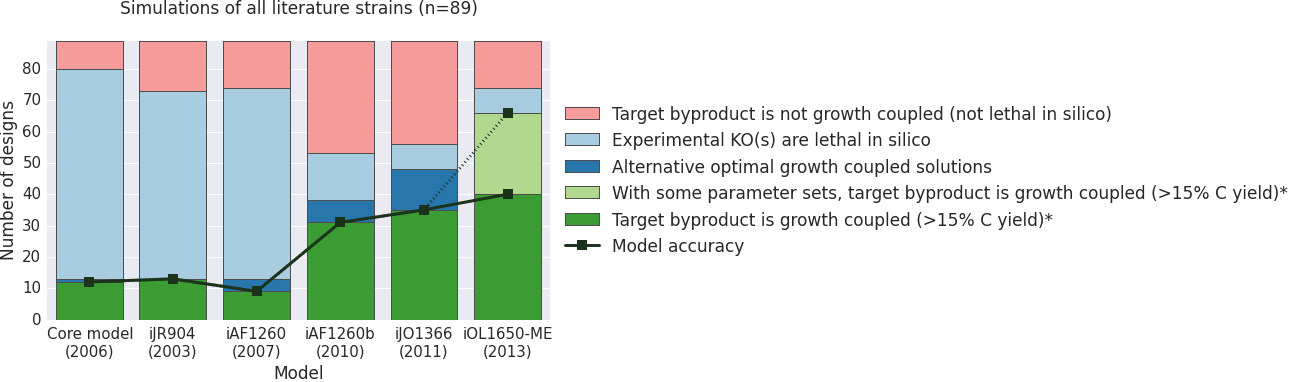

In [258]:
plot_model_growth_coupled_categories(growth_coupled_categories, gc_line=True)
# on the poster, also note the req'ment for greedy knockouts
plt.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-categories.pdf')

In [259]:
growth_coupled_categories

<ModelGrowthCoupledCategories(target=all, models=['e_coli_core', 'iJR904', 'iAF1260', 'iAF1260b', 'iJO1366', 'ME'], total=89, categories=['Target byproduct is growth coupled (>15% C yield)*', 'With some parameter sets, target byproduct is growth coupled (>15% C yield)*', 'Alternative optimal growth coupled solutions', 'Experimental KO(s) are lethal in silico ', 'Target byproduct is not growth coupled (not lethal in silico)'], count_arrays=[[ 12.  13.   9.  31.  35.  40.]
 [  0.   0.   0.   0.   0.  26.]
 [  1.   0.   4.   7.  13.   0.]
 [ 67.  60.  61.  15.   8.   8.]
 [  9.  16.  15.  36.  33.  15.]])>

In [260]:
def percentages_for_category(cats, cat_substring):
    cat = [x for x in cats.categories if cat_substring in x][0]
    return growth_coupled_categories.count_arrays[growth_coupled_categories.categories.index(cat)] / growth_coupled_categories.total * 100

In [261]:
percentages_for_category(growth_coupled_categories, 'coupled')

array([ 13.48314607,  14.60674157,  10.11235955,  34.83146067,
        39.3258427 ,  44.94382022])

In [262]:
percentages_for_category(growth_coupled_categories, 'lethal')

array([ 75.28089888,  67.41573034,  68.53932584,  16.85393258,
         8.98876404,   8.98876404])

## By target

In [263]:
targets = all_sims_no_wildtype.reset_index().sort_values(by='year').target.unique()
gc_category = [calculate_model_growth_coupled_categories(all_sims_no_wildtype, target=target, category_list=growth_coupled_categories.categories)
               for target in targets]

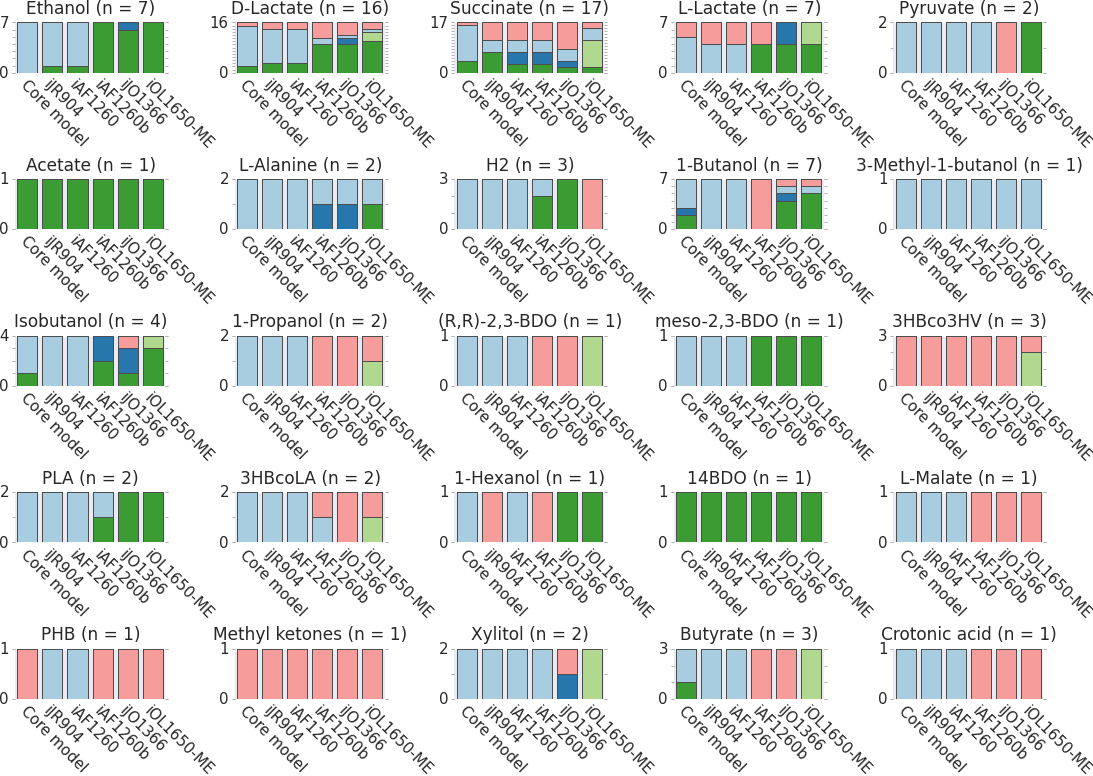

In [264]:
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
fig.tight_layout(pad=0.4, w_pad=2, h_pad=5.0)
for gc, axis in izip_longest(gc_category, axes.flatten()):
    if not gc:
        axis.axis('off')
        continue
    plot_model_growth_coupled_categories(gc, axis=axis, show_legend=False, 
                                         y_lim_max_label=True)
    axis.set_xlabel('')
    axis.set_ylabel('')
    # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
    axis.set_xticklabels([])
    axis.set_xticks([x + 0.1 for x in range(len(gc.models))], minor=True)
    axis.set_xticklabels(rename_models(gc.models, year=False), rotation=-45, horizontalalignment='left', minor=True)
    axis.get_yaxis().set_tick_params(which='both', direction='out', color=(0.7, 0.7, 0.7), 
                                     width=1, length=3)
fig.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-categories-by-target.pdf')

## With ALE

In [265]:
with_ale = all_sims_no_wildtype[all_sims_no_wildtype.evolved != 'no']
growth_coupled_categories_ale = calculate_model_growth_coupled_categories(with_ale)

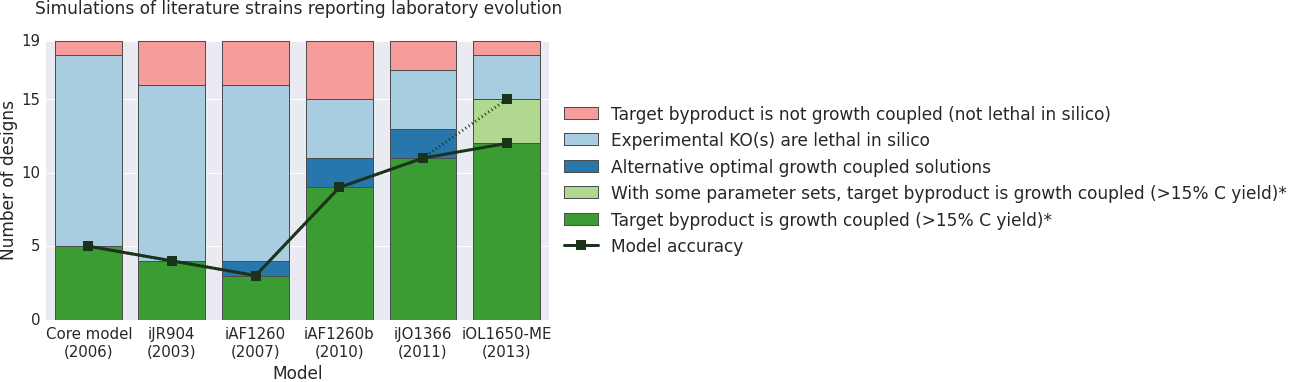

In [266]:
ax = plot_model_growth_coupled_categories(growth_coupled_categories_ale, gc_line=True)
ax.set_yticks([0, 5, 10, 15, growth_coupled_categories_ale.total])
ax.set_title('Simulations of literature strains reporting laboratory evolution')
plt.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-categories-ale.pdf')

In [267]:
# targets_ale = with_ale.reset_index().sort_values(by='year').target.unique()
# gc_category_ale = [calculate_model_growth_coupled_categories(with_ale, target=target, category_list=growth_coupled_categories.categories)
#                for target in targets_ale]

# fig, axes = plt.subplots(6, 4, figsize=(12, 11))
# fig.tight_layout(pad=0.4, w_pad=2, h_pad=4.0)
# for gc, axis in izip_longest(gc_category_ale, axes.flatten()):
#     if not gc:
#         axis.axis('off')
#         continue
#     plot_model_growth_coupled_categories(gc, axis=axis, show_legend=False, 
#                                          y_lim_max_label=True)
#     axis.set_xlabel('')
#     axis.set_ylabel('')
#     # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
#     axis.set_xticklabels([])
#     axis.set_xticks([x + 0.2 for x in range(len(gc.models))], minor=True)
#     axis.set_xticklabels(rename_models(gc.models, year=False), rotation=-35, horizontalalignment='left', minor=True)
#     axis.get_yaxis().set_tick_params(which='both', direction='out', color=(0.7, 0.7, 0.7), 
#                                      width=1, length=3)
# fig.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-categories-by-target-ale-9-4-15-microaerobic.pdf')

# Model size

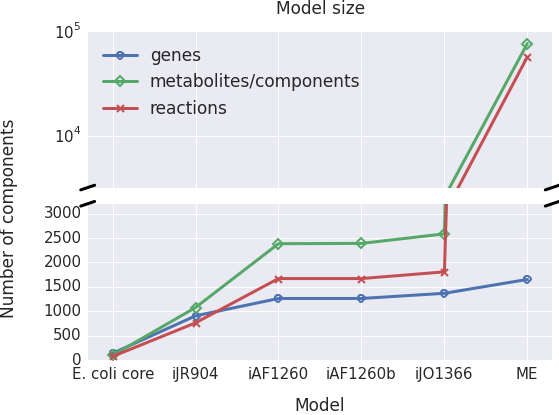

In [268]:
size = [('E. coli core', (137, 95, 72)),
        ('iJR904', (904, 1075, 761)),
        ('iAF1260', (1260, 2382, 1668)),
        ('iAF1260b', (1260, 2388, 1668)),
        ('iJO1366', (1366, 2583, 1805)),
        ('ME', (1650, 76414, 56902))]
labels = ['genes', 'metabolites/components', 'reactions']
markers = ['o', 'D', 'x']
figsize = (7, 5)
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=figsize)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
for j, ax in enumerate((ax1, ax2)):
    f = ax.plot if j == 1 else ax.semilogy
    for i in range(len(size[0][1])):
        f(range(len(size)), [x[1][i] for x in size],
                label=labels[i], marker=markers[i], fillstyle='none',
                linewidth=3, markeredgewidth=2, ms=7)
    ax.set_xlim([-0.3, len(size)-1+0.3])
    
ax1.set_ylabel('Number of components')
ax1.yaxis.set_label_coords(-0.15, -0.2)
ax1.legend(loc='upper left')
ax1.set_ylim([3200, 100000])
ax1.yaxis.labelpad = 15
ax2.set_ylim([0, 3200])
ax2.set_xticklabels([0] + [x[0] for x in size])
ax2.set_xlabel('Model')
ax2.xaxis.labelpad = 15

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off') # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax1.set_title('Model size', y=1.08)

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax1.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal
plt.savefig('/Users/zaking/lab/hindsight/figs/model-size.pdf')

# Sampling overview

In [269]:
samp = pd.read_pickle('../data/sampling_table.pickle')

In [270]:
succ = all_sims_no_wildtype[all_sims_no_wildtype.target_exchange == 'EX_succ_e']
succ_samp = (
    succ.loc[idx[:, ['ME']], ['target_exchange']]
    .merge(samp, left_index=True, right_index=True, how='left')
    .dropna(subset=['target_exchange_fluxes'])
)
succ_samp

,,target_exchange,target_exchange_fluxes
paper,model,,
Blankschien2010-hm,ME,EX_succ_e,"[{u'growth_rate': 0.2259766006, u'exchange_flu..."
Donnelly1998-sb,ME,EX_succ_e,"[{u'growth_rate': 0.5862425613, u'exchange_flu..."
Lee2005-xo_2,ME,EX_succ_e,"[{u'growth_rate': 0.5767187881, u'exchange_flu..."
Ma2013-nl,ME,EX_succ_e,"[{u'growth_rate': 0.6799848938, u'exchange_flu..."
Sanchez2005-cz,ME,EX_succ_e,"[{u'growth_rate': 0.4636699295, u'exchange_flu..."
Sanchez2005-mu,ME,EX_succ_e,"[{u'growth_rate': 0.4519657135, u'exchange_flu..."
Singh2011-am,ME,EX_succ_e,"[{u'growth_rate': 0.3442468262, u'exchange_flu..."
Stols1997-kf,ME,EX_succ_e,"[{u'growth_rate': 0.6798929977, u'exchange_flu..."
Stols1997-yg,ME,EX_succ_e,"[{u'growth_rate': 0.658865509, u'exchange_flux..."


In [271]:
repl = {
    'Blankschien2010-hm': '(Blankschien, 2010) [53]',
    'Donnelly1998-sb': '(Donnelly, 1998) [54]',
    'Lee2005-xo_2': '(Lee, 2005) [55]',
    'Ma2013-nl': '(Ma, 2013) [56]',
    'Sanchez2005-cz': '(Sanchez, 2005) [57]',
    'Sanchez2005-mu': '(Sanchez, 2005) [58]',
    'Singh2011-am': '(Singh, 2011) [59]',
    'Stols1997-kf': '(Stols, 1997) [60]',
    'Stols1997-yg': '(Stols, 1997) [26]',
    'Vemuri2002-xk': '(Vemuri, 2002) [61]',
    'Zhang2010-ud': '(Zhang, 2010) [62]',
}

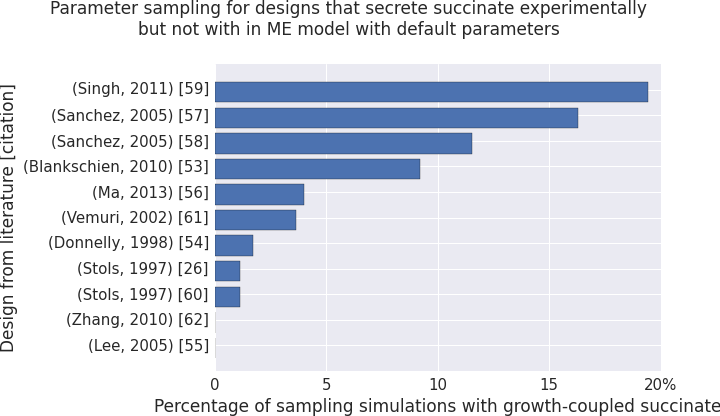

In [272]:
data = []
for ind, row in succ_samp.iterrows():
    l = row.target_exchange_fluxes
    co = float(len([x for x in l if x['exchange_yield'] >= growth_coupled_cutoff])) / len(l) * 100
    data.append((repl[ind[0]], co))
labels, width = zip(*sorted(data, key=lambda x: x[1]))
fig, ax = plt.subplots()
ax.barh([x + 0.5 for x in range(len(height))], width)
ax.set_yticks([x + 1.0 for x in range(len(labels))])
ax.set_yticklabels(labels)
ax.set_ylabel('Design from literature [citation]')
ax.set_xticklabels(['%s%%' % x if i == 4 else x for i, x in enumerate(range(0, 25, 5))])
ax.set_xlabel('Percentage of sampling simulations with growth-coupled succinate')
ax.set_title('Parameter sampling for designs that secrete succinate experimentally \nbut not with in ME model with default parameters', 
             y=1.08, x=0.3)
plt.savefig('/Users/zaking/Dropbox (Personal)/lab/hindsight/figs/succinate-sampling.pdf')

# Pyruvate variability

In [273]:
model_comp = get_model_comparison(all_sims_no_wildtype, 'Zhang2007-fu_2', plot_yield=True)

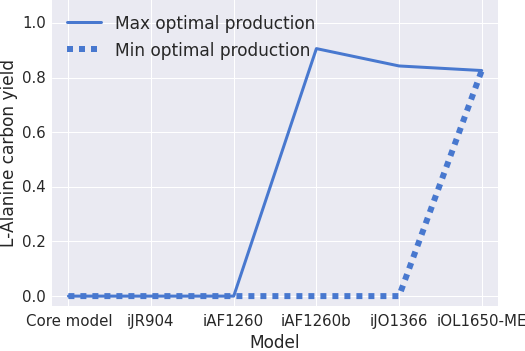

In [274]:
fig, axis = plt.subplots()
plot_model_comparison(axis, model_comp)
axis.set_ylabel('L-Alanine carbon yield')
fig.savefig('/Users/zaking/lab/hindsight/figs/model-variability.pdf')

# Lethal phenotypes

In [275]:
res = pd.read_pickle('../data/false_negatives.pickle')
# sort to avoid duplicates
res['reactions_sorted'] = res.reactions.apply(lambda x: tuple(sorted(x)))

In [276]:
false_neg_counts = (res
 .reset_index()
 # example_genotype is an arbitrary column to count
 .loc[:, ['model', 'reactions_sorted', 'example_genotype']]
 # count by model/reactions pair
 .groupby(['model', 'reactions_sorted'])
 .count()
 # get rid of arbitrary label
 .rename(columns=lambda x: 'count')
 # sort by count for each model
 .reset_index()
 .sort_values(by=['model', 'count', 'reactions_sorted'], inplace=False, ascending=False)
 # get examples of lethal genotypes
 .merge(res.reset_index(), on=['model', 'reactions_sorted'], how='left')
 # don't care about growth rate
 .drop('growth_rate', axis=1)
 # only get one example for each false negative in a model
 .drop_duplicates(['model', 'reactions_sorted']))

In [277]:
false_neg_summary = false_neg_counts.groupby('model').count()
false_neg_summary

,reactions_sorted,count,example_paper,reactions,example_genotype
model,,,,,
e_coli_core,8,8,8,8,8
iAF1260,11,11,11,11,11
iAF1260b,14,14,14,14,14
iJO1366,9,9,9,9,9
iJR904,10,10,10,10,10


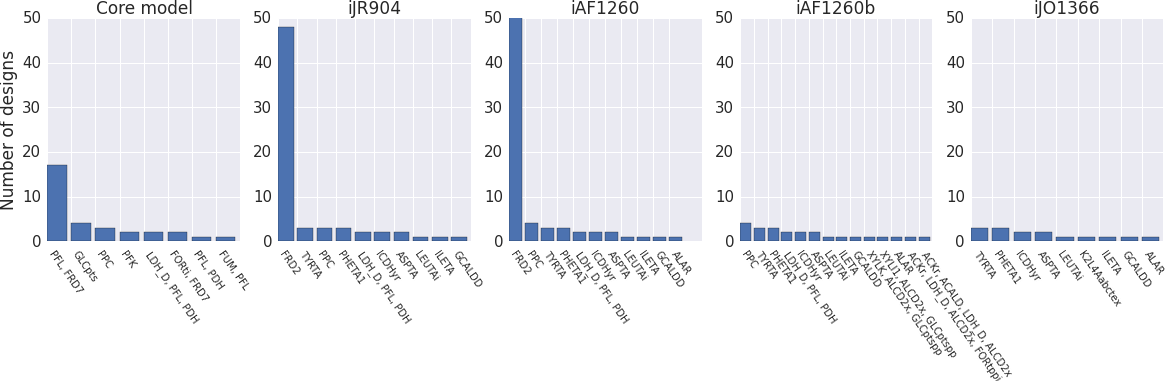

In [278]:
fig, axs = plt.subplots(1, 5, figsize=(20,4))
g = false_neg_counts.loc[:, ['reactions', 'count', 'model']].groupby('model', sort=False)
all_axs = axs.flatten()
model_order = ['e_coli_core', 'iJR904', 'iAF1260', 'iAF1260b', 'iJO1366']
for i, gs in enumerate(g):
    model = gs[0]
    ind = model_order.index(model)
    ax = all_axs[ind]
    ax.bar(range(len(gs[1])), map(int, gs[1]['count']))
    ax.set_title('Core model' if model == 'e_coli_core' else model)
    if ind == 0:
        ax.set_ylabel('Number of designs')
    ax.set_xticks([x for x in range(len(gs[1]))])
    ax.set_xticklabels([', '.join(x) for x in gs[1]['reactions']], rotation=-55, fontsize=10, ha='left')
    ax.set_ylim(top=50)
fig.savefig('/Users/zaking/Dropbox (Personal)/lab/hindsight/figs/false-negatives-summary.pdf')

In [279]:
# Distribution of target secretion yield

# order_df = all_sims_no_wildtype.xs('iJO1366', level='model').loc[:, ['target_exchange', 'c_byproduct_order']]

# len(order_df)

# has_data = order_df[~(order_df.c_byproduct_order == '-') & ~(order_df.c_byproduct_order == 'nd')]

# len(has_data)

# target_in = has_data[has_data.apply(lambda x: x.target_exchange in [x[0] for x in x.c_byproduct_order], axis=1)]

# len(target_in)

# target_not_in = has_data[~has_data.apply(lambda x: x.target_exchange in [z[0] for z in x.c_byproduct_order], axis=1)]
# target_not_in

# target_in_vals = target_in.apply(lambda x: [z[1] for z in x.c_byproduct_order if z[0] == x.target_exchange][0], axis=1)
# target_in_rank = target_in.apply(lambda x: [z[0] for z in x.c_byproduct_order].index(x.target_exchange) + 1, axis=1)

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
# fig.tight_layout(w_pad=2)
# target_in_vals.hist(bins=30, ax=ax1)
# ax1.set_xlabel('Carbon yield of measured products')
# ax1.set_ylabel('Number of designs')
# height, left = np.histogram(target_in_rank, bins=[0.5, 1.5, 2.5, 3.5, 4.5])
# ax2.bar(left[:-1], height, width=1)
# ax2.set_xlabel('Secretion order rank')
# ax2.set_xlim([0.5, 4.5])
# _=ax2.set_xticks([x+1 for x in range(4)])
# plt.savefig('/Users/zaking/lab/hindsight/figs/target-in-secretion-order.pdf')

# float(len(target_in_vals[target_in_vals > 0.5])) / len(target_in_vals), len(target_in_vals[target_in_vals > 0.5]), len(target_in_vals)

# len(target_in_rank[target_in_rank == 1]), len(target_in_rank)

In [280]:
# native = all_sims_no_wildtype[all_sims_no_wildtype.loc[:, 'native'].fillna(method='pad') == True]
# nonnative = all_sims_no_wildtype[~all_sims_no_wildtype.loc[:, 'native'].fillna(method='pad') == False]

## All

# gc_native = calculate_model_growth_coupled(native)
# gc_nonnative = calculate_model_growth_coupled(nonnative)

# gc_native = calculate_model_growth_coupled(native)
# gc_nonnative = calculate_model_growth_coupled(nonnative)

# fig, ax = plt.subplots(figsize=(7.5, 4))
# fig.tight_layout()
# plot_model_growth_coupled(gc_native, gc_nonnative, y_tick_step=10, axis=ax, 
#                           labels=['Native metabolite', 'Nonnative metabolite'])
# ax.set_xlabel('Model', labelpad=15)
# ax.set_ylabel('Number of designs', labelpad=15)
# ax.legend(loc='upper left')
# plt.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-designs.pdf')

# growth_coupled_gradient = calculate_model_growth_coupled_gradient(all_sims_no_wildtype)

# with sns.axes_style('ticks'):
#     fig, ax = plt.subplots(figsize=(7.5, 4))
#     sns.despine()
# fig.tight_layout()
# plot_model_growth_coupled_gradient(growth_coupled_gradient, y_tick_step=10, axis=ax)
# ax.set_xlabel('Model', labelpad=15)
# ax.set_ylabel('Number of designs', labelpad=15)
# ax.legend(loc='upper left')
# #plt.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-designs-gradient.pdf')

# plot_model_growth_coupled_gradient_colorbar()

# ## By target

# targets = all_sims_no_wildtype.reset_index().sort_values(by='year').target.unique()
# gc_by_target_n = [calculate_model_growth_coupled(native, target=target)
#                   for target in targets]
# gc_by_target_nn = [calculate_model_growth_coupled(nonnative, target=target)
#                    for target in targets]

# fig, axes = plt.subplots(4, 6, figsize=(18, 8))
# fig.tight_layout(pad=0.4, w_pad=2, h_pad=4.0)
# for gc, gc2, axis in zip(gc_by_target_n, gc_by_target_nn, axes.flatten()):
#     total = gc.total + gc2.total
#     plot_model_growth_coupled(gc, gc2, axis=axis,
#                               y_tick_step=(1 if total <= 5 else (2 if total <= 10 else 5)))
#     axis.set_xlabel('')
#     axis.set_ylabel('')
#     # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
#     axis.set_xticklabels([])
#     axis.set_xticks([x + 0.2 for x in range(len(gc.models))], minor=True)
#     axis.set_xticklabels(gc.models, rotation=-35, horizontalalignment='left', minor=True)
# fig.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-designs-by-target.pdf')

### Gradient with min yield (Broken)

# targets = all_sims_no_wildtype.reset_index().sort_values(by='year').target.unique()
# gc_gradient_by_target = [calculate_model_growth_coupled_gradient(all_sims_no_wildtype, target)
#                          for target in targets]

# with sns.axes_style('ticks'):
#     fig, axes = plt.subplots(4, 6, figsize=(18, 8))
#     #sns.despine()
# fig.tight_layout(pad=0.4, w_pad=2, h_pad=4.0)
# for i, (gc, axis) in enumerate(izip_longest(gc_gradient_by_target, axes.flatten())):
#     if i == len(gc_gradient_by_target):
#         #plot_model_growth_coupled_gradient_colorbar(axis)
#         break
#     total = gc.total
#     plot_model_growth_coupled_gradient(gc, axis=axis, y_tick_step=(1 if total <= 5 else (2 if total <= 10 else 5)))
#     axis.set_xlabel('')
#     axis.set_ylabel('')
#     # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
#     axis.set_xticklabels([])
#     axis.set_xticks([x + 0.2 for x in range(len(gc.models))], minor=True)
#     axis.set_xticklabels(gc.models, rotation=-35, horizontalalignment='left', minor=True)
#     axis.tick_params(axis='x', which='minor', width=0)
#     axis.tick_params(axis='x', which='major', top='off')

# plot_model_growth_coupled_gradient_colorbar()

### With max yield

# targets = all_sims_no_wildtype.reset_index().sort_values(by='year').target.unique()
# gc_gradient_by_target_max = [calculate_model_growth_coupled_gradient(all_sims_no_wildtype, target, use_max_yield=True)
#                              for target in targets]

# with sns.axes_style('ticks'):
#     fig, axes = plt.subplots(8, 6, figsize=(18, 16))
#     #sns.despine()
# fig.tight_layout(pad=0.4, w_pad=2, h_pad=4.0)
# for gc, axis in izip(list(chain.from_iterable(izip(gc_gradient_by_target, gc_gradient_by_target_max))), axes.flatten()):
#     total = gc.total
#     plot_model_growth_coupled_gradient(gc, axis=axis, y_tick_step=(1 if total <= 5 else (2 if total <= 10 else 5)))
#     axis.set_xlabel('')
#     axis.set_ylabel('')
#     # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
#     axis.set_xticklabels([])
#     axis.set_xticks([x + 0.2 for x in range(len(gc.models))], minor=True)
#     axis.set_xticklabels(gc.models, rotation=-35, horizontalalignment='left', minor=True)
#     axis.tick_params(axis='x', which='minor', width=0)
#     axis.tick_params(axis='x', which='major', top='off')

## By aerobicity (Broken)

# gc_aer_n = [calculate_model_growth_coupled(native[native.Aerobicity != 'aerobic'], target='all'),
#             calculate_model_growth_coupled(native[native.Aerobicity == 'aerobic'], target='all')]
# gc_aer_nn = [calculate_model_growth_coupled(nonnative[nonnative.Aerobicity != 'aerobic'], target='all'),
#              calculate_model_growth_coupled(nonnative[nonnative.Aerobicity == 'aerobic'], target='all')]
# labels_aer = ['Anaerobic/microaerobic', 'Aerobic']

# fig, axes = plt.subplots(1, 2, figsize=(7, 2))
# fig.tight_layout(pad=0.4, w_pad=2.5, h_pad=4.0)
# for i, (gc, gc2, axis) in enumerate(zip(gc_aer_n, gc_aer_nn, axes.flatten())):
#     total = gc.total + gc2.total
#     plot_model_growth_coupled(gc, gc2, axis=axis,
#                               y_tick_step=(1 if total <= 3 else 20))
#     axis.set_xlabel('')
#     axis.set_ylabel('')
#     # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
#     axis.set_xticklabels([])
#     axis.set_xticks([x + 0.2 for x in range(len(gc.models))], minor=True)
#     axis.set_xticklabels(gc.models, rotation=-35, horizontalalignment='left', minor=True)
#     axis.set_title(labels_aer[i] + ' (n={})'.format(total), y=1.08)
# fig.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-designs-by-aerobicity.pdf')

## By additions

# gc_add_n = [calculate_model_growth_coupled(native[native.Additions == 'none'], target='all'),
#             calculate_model_growth_coupled(native[native.Additions != 'none'], target='all')]
# gc_add_nn = [calculate_model_growth_coupled(nonnative[nonnative.Additions == 'none'], target='all'),
#              calculate_model_growth_coupled(nonnative[nonnative.Additions != 'none'], target='all')]
# labels_add = ['Native pathway', 'Heterologous pathway']

# fig, axes = plt.subplots(1, 2, figsize=(7, 2))
# fig.tight_layout(pad=0.4, w_pad=2, h_pad=4.0)
# for i, (gc, gc2, axis) in enumerate(zip(gc_add_n, gc_add_nn, axes.flatten())):
#     total = gc.total + gc2.total
#     plot_model_growth_coupled(gc, gc2, axis=axis,
#                               y_tick_step=10)
#     axis.set_xlabel('')
#     axis.set_ylabel('')
#     # trick to move labels (http://stackoverflow.com/questions/16162514/how-can-i-move-a-tick-label-onlywithout-moving-corresponding-tick)
#     axis.set_xticklabels([])
#     axis.set_xticks([x + 0.2 for x in range(len(gc.models))], minor=True)
#     axis.set_xticklabels(gc.models, rotation=-35, horizontalalignment='left', minor=True)
#     axis.set_title(labels_add[i] + ' (n={})'.format(total), y=1.08)
# fig.savefig('/Users/zaking/lab/hindsight/figs/growth-coupled-designs-by-additions.pdf')